<h2>Прогнозирование временных рядов с LSTM</h2>


Продвинутые модели глубокого обучения, такие как Long Short Term Memory Networks (LSTM), способны улавливать закономерности в данных временных рядов и поэтому могут быть использованы для прогнозирования будущего тренда данных.

In [18]:
!pip3 install torch
!pip3 install sklearn

  Using cached https://files.pythonhosted.org/packages/a1/1f/a372f2e9f0a54fc479fcee3ac072f8cd5091054e9d7293dd4372338e5277/torch-1.9.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fe/ca/75fac5856ab5cfa51bbbcefa250182e50441074fdc3f803f6e76451fab43/dataclasses-0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2e/35/6c4fff5ab443b57116cb1aad46421fb719bed2825664e8fe77d66d99bcbc/typing_extensions-3.10.0.0-py3-none-any.whl
    100% |████████████████████████████████| 20.0MB 95kB/s  eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c8/89/63171228d5ced148f5ced50305c89e8576ffc695a90b58fe5bb602b910c2/scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 307kB 2.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for s

In [1]:
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# встроенные датасеты библиотеки seaborn
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [4]:
# для анализа возьмем встроенный датасет flights
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [5]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


Построим график частоты поездок пассажиров в месяц.

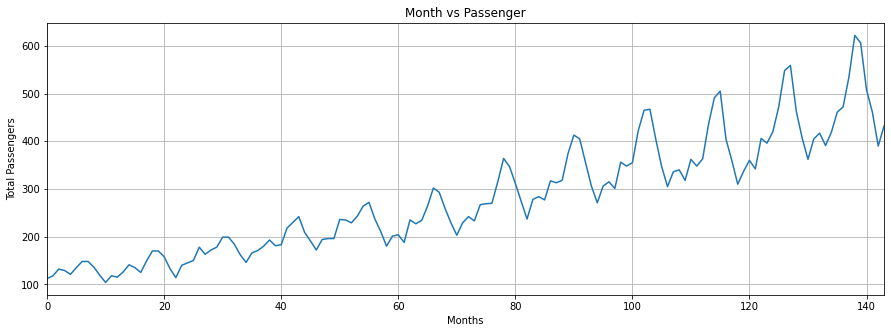

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

<b>Выводы:</b>

Со временем среднее количество пассажиров, путешествующих воздушным транспортом, увеличилось. Количество пассажиров, путешествующих в течение года, колеблется, что имеет смысл, потому что во время летних или зимних каникул количество путешествующих пассажиров увеличивается по сравнению с другими частями года.

<h2>Подготовка данных</h2>

In [12]:
data = flight_data['passengers'].values

Разделим наш набор данных на обучающие и тестовые наборы. Алгоритм LSTM будет обучаться на обучающем наборе. Затем модель будет использоваться для составления прогнозов на тестовом наборе. Прогнозы будут сравниваться с фактическими значениями в тестовом наборе для оценки производительности обученной модели.

Первые 132 записи будут использоваться для обучения модели, а последние 12 записей будут использоваться в качестве тестового набора.

In [13]:
test_data_size = 12

train_data = data[:-test_data_size]
test_data = data[-test_data_size:]

In [12]:
print(test_data)

132    417
133    391
134    419
135    461
136    472
137    535
138    622
139    606
140    508
141    461
142    390
143    432
Name: passengers, dtype: int64


Выполним минимальное/максимальное масштабирование набора данных, которое нормализует данные в определенном диапазоне минимальных и максимальных значений. Мы будем использовать класс MinMaxScaler из модуля sklearn.preprocessing для масштабирования наших данных.<br>

Нормализация данных применяется только к обучающим данным, а не к тестовым. 

In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [15]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


Следующим шагом является преобразование нашего набора данных в тензоры, поскольку модели PyTorch обучаются с использованием тензоров. Чтобы преобразовать набор данных в тензоры, мы передадим наш набор данных конструктору объекта FloatTensor.

In [17]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

Последний этап предварительной обработки - преобразование обучающих данных в последовательности и соответствующие метки.

Можно использовать любую длину последовательности, и это зависит от знания предметной области. В нашем наборе данных удобно использовать последовательность длиной 12, так как у нас есть ежемесячные данные, а в году 12 месяцев. Если бы у нас были ежедневные данные, лучшая длина последовательности была бы 365, то есть количество дней в году. Поэтому мы установим длину входной последовательности для обучения равной 12.

In [18]:
train_window = 12

Определим функцию с именем `create_input_sequences` . Функция примет необработанные входные данные и вернет список кортежей. В каждом кортеже первый элемент будет содержать список из 12 пунктов, соответствующих количеству пассажиров, путешествующих за 12 месяцев, второй элемент кортежа будет содержать один пункт, т. е. количество пассажиров за 12+1-й месяц.

In [19]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

Создадим последовательности и соответствующие метки для обучения

In [20]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [22]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

Каждый элемент является кортежем, где первый элемент состоит из 12 элементов последовательности, а второй элемент кортежа содержит соответствующую метку.

<h2>Создание модели LSTM</h2>

Определим класс LSTM , который наследуется от класса nn.Module библиотеки PyTorch.

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

Конструктор класса `LSTM` принимает три параметра:

`input_size` : Соответствует количеству объектов во входных данных. Хотя длина нашей последовательности равна 12, для каждого месяца у нас есть только 1 значение, то есть общее количество пассажиров, поэтому входной размер будет равен 1.
`hidden_layer_size` : Определяет количество скрытых слоев вместе с количеством нейронов в каждом слое. У нас будет один слой из 100 нейронов.
`output_size` : Количество элементов в выводе, так как мы хотим предсказать количество пассажиров на 1 месяц в будущем, размер вывода будет равен 1.
Далее в конструкторе мы создаем переменные `hidden_layer_size` , `lstm` , `linear` и `hidden_cell` . Алгоритм LSTM принимает три входа: предыдущее скрытое состояние, предыдущее состояние ячейки и текущий вход. Переменная hidden_cell содержит предыдущее скрытое состояние и состояние ячейки. Переменные `lstm` и `linear` `layer` используются для создания слоев LSTM и linear.

Внутри метода `forward` в качестве параметра передается `input_seq` , который сначала передается через слой `lstm` . Выход слоя `lstm` – это скрытое состояние и состояние ячейки на текущем временном шаге, а также выход. Выходные данные из слоя `lstm` передаются в слой `linear` . Прогнозируемое количество пассажиров сохраняется в последнем элементе списка `predictions` , который возвращается вызывающей функции.

Создадим объект класса `LSTM ()`, определим функцию потерь и оптимизатора. Поскольку мы решаем задачу классификации, мы будем использовать кросс-энтропийные потери . Для функции оптимизатора мы будем использовать `adam optimizer`.

In [26]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


<h2>Обучение модели</h2>

Будем тренировать нашу модель в течение 150 эпох.Потери будут печататься через каждые 25 эпох.

In [28]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00941816
epoch:  26 loss: 0.01106068
epoch:  51 loss: 0.00001044
epoch:  76 loss: 0.00147645
epoch: 101 loss: 0.00004347
epoch: 126 loss: 0.00030516
epoch: 149 loss: 0.0004035859


<h2>Прогнозы</h2>

Когда модель обучена, можно начать делать прогнозы. Поскольку тестовый набор содержит данные о пассажирах за последние 12 месяцев, а модель обучена делать прогнозы, используя длину последовательности 12. Сначала мы отфильтруем последние 12 значений из обучающего набора

In [29]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


Можно сравнить приведенные выше значения с последними 12 значениями списка данных train_data_normalized .

Первоначально элемент test_inputs будет содержать 12 элементов. Внутри цикла for эти 12 элементов будут использоваться для предсказания первого элемента из тестового набора, то есть элемента под номером 133. Затем значение прогноза будет добавлено в список test_inputs . Во время второй итерации снова будут использованы последние 12 элементов в качестве входных данных, и будет сделано новое предсказание, которое затем снова будет добавлено в список test_inputs . Цикл for будет выполняться 12 раз, так как в тестовом наборе имеется 12 элементов. В конце цикла список test_inputs будет содержать 24 элемента. Последние 12 пунктов будут прогнозируемыми значениями для тестового набора.

In [30]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

test_inputs содержит 24 элемента. Последние 12 прогнозируемых элементов:

In [31]:
test_inputs[fut_pred:]

[0.4865908920764923,
 0.8709333539009094,
 1.2424625158309937,
 1.4307588338851929,
 1.5588828325271606,
 1.6361677646636963,
 1.68451988697052,
 1.7165820598602295,
 1.7384032011032104,
 1.7534167766571045,
 1.7641631364822388,
 1.77222740650177]

Можно получить различные значения в зависимости от весов, используемых для обучения LSTM.

Поскольку мы нормализовали набор данных для обучения, прогнозируемые значения также нормализуются. Нам нужно преобразовать нормализованные прогнозные значения в фактические прогнозные значения. Мы можем сделать это, передав нормализованные значения в метод inverse_transform объекта min/max scaler, который мы использовали для нормализации нашего набора данных.

In [32]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[442.19942795]
 [529.63733801]
 [614.16022235]
 [656.99763471]
 [686.1458444 ]
 [703.72816646]
 [714.72827429]
 [722.02241862]
 [726.98672825]
 [730.40231669]
 [732.84711355]
 [734.68173498]]


Построим график предсказанных значений относительно фактических. 

In [36]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


В приведенном выше скрипте мы создаем список, содержащий числовые значения за последние 12 месяцев. Первый месяц имеет значение индекса 0, поэтому последний месяц будет иметь индекс 143.

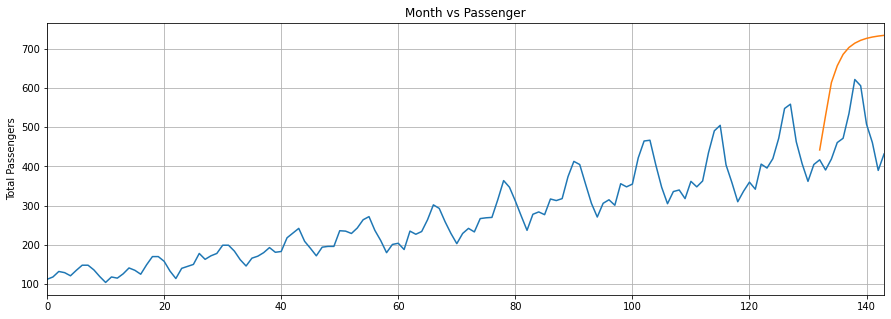

In [37]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

Предсказания, сделанные нашим LSTM, изображены оранжевой линией. Можно видеть, что наш алгоритм не слишком точен, но все же он смог зафиксировать восходящий тренд для общего числа пассажиров, путешествующих за последние 12 месяцев, а также случайные колебания. Можно попробовать с большим количеством эпох и с большим количеством нейронов.

Чтобы лучше видеть результат, мы можем построить график фактического и прогнозируемого количества пассажиров за последние 12 месяцев следующим образом:

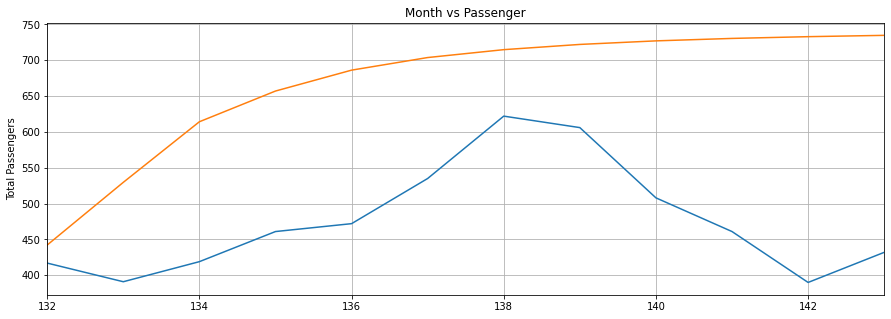

In [38]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()


Опять же, прогнозы не очень точны, но алгоритм смог уловить тенденцию, что количество пассажиров в будущих месяцах должно быть выше, чем в предыдущие месяцы.